## BBC Experiment [Part 4 - Basic Segmentation Bro]

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
path=Path('../data/bbc')

In [5]:
path.ls()

[PosixPath('../data/bbc/train.json'),
 PosixPath('../data/bbc/train_classification_labels.csv'),
 PosixPath('../data/bbc/test_classification_labels.csv'),
 PosixPath('../data/bbc/test'),
 PosixPath('../data/bbc/test.json'),
 PosixPath('../data/bbc/.DS_Store'),
 PosixPath('../data/bbc/train_masks'),
 PosixPath('../data/bbc/train'),
 PosixPath('../data/bbc/models'),
 PosixPath('../data/bbc/test_masks')]

In [6]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('../data/bbc/train/P2050886.jpg'),
 PosixPath('../data/bbc/train/P2050729.jpg'),
 PosixPath('../data/bbc/train/P2050513.jpg')]

In [7]:
lbl_names = get_image_files(path/'train_masks')
lbl_names[:3]

[PosixPath('../data/bbc/train_masks/P2050393.png'),
 PosixPath('../data/bbc/train_masks/P2050807.png'),
 PosixPath('../data/bbc/train_masks/P2050940.png')]

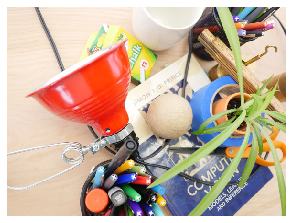

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return path/'train_masks'/(x.stem + '.png')

classes = array(['background', 'brick', 'ball', 'cylinder'])

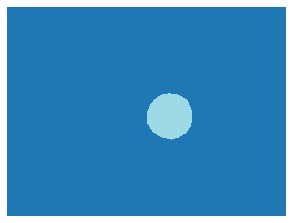

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
unique(mask.data)

array([ 0, 64])

In [15]:
src = (SegmentationItemList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [25]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [26]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc/train;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc/train;

Test: None

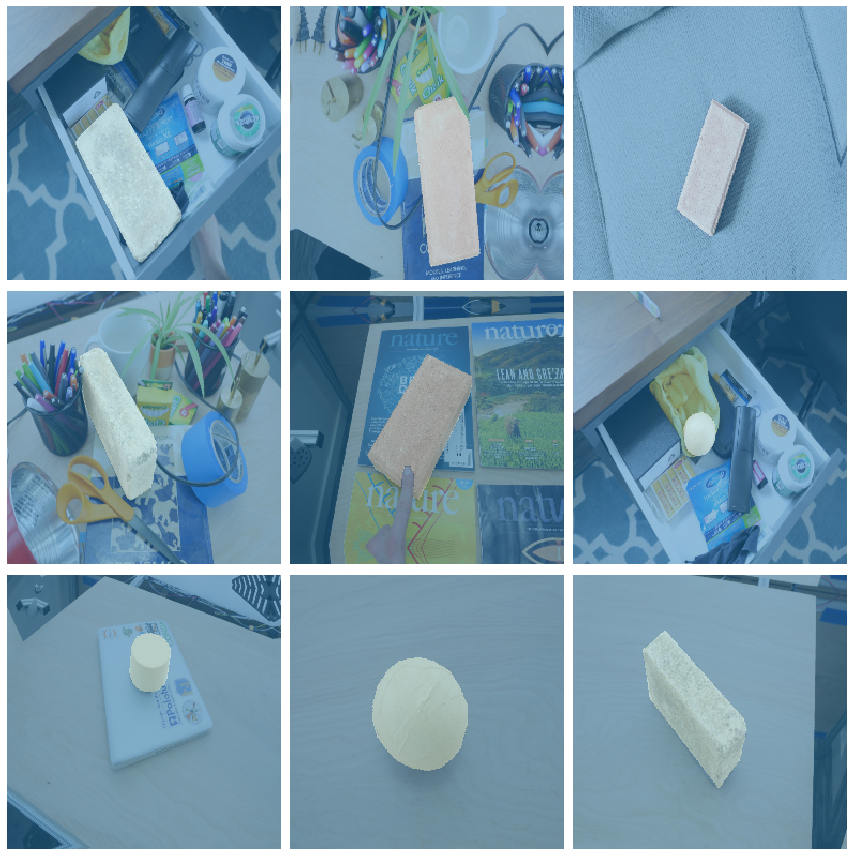

In [27]:
data.show_batch(3, figsize=(12,12))

In [37]:
learn=cnn_learner(data, models.resnet18)

In [38]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

- BatchNorm2d          [512, 8, 8]
- How can we build this up back to a full image?
- In my lecture, I should be able to borrow some from my GAN lecture on **transposed convolutions**: https://github.com/stephencwelch/dl-workshop/blob/master/generative_adversarial_networks/Generative%20Adversarial%20Networks.ipynb


In [39]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True))

In [46]:
custom_head=nn.Sequential(conv_trans(512, 256))

In [44]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head)

In [45]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [60]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

In [61]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head)

In [62]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

- Sweet! 
- I guess that I need like a loss function and performance metric now?

In [63]:
x,y =learn.data.one_batch()

In [64]:
x.shape, y.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

In [65]:
yhat=learn.model(x.to('cuda'))

In [66]:
yhat.shape

torch.Size([16, 4, 256, 256])

...So, can Ijust do cross entropy? is that what people normally do?

In [ ]:
learn2=unet_learner(data, models.resnet17)